# Time Series in Python
# Practical approach
# Homework task

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline



from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

В этой домашней работе вам предстоит поработать с двумя временными рядами, один - уже знакомый ряд с тратой внутриигровой валюты `currency`, второй - установки по дням в одном из наших приложений, `installs`

In [2]:
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])
installs = pd.read_csv('installs.csv', index_col=['Time'], parse_dates=['Time'])

Снова посмотрим на графики временных рядов

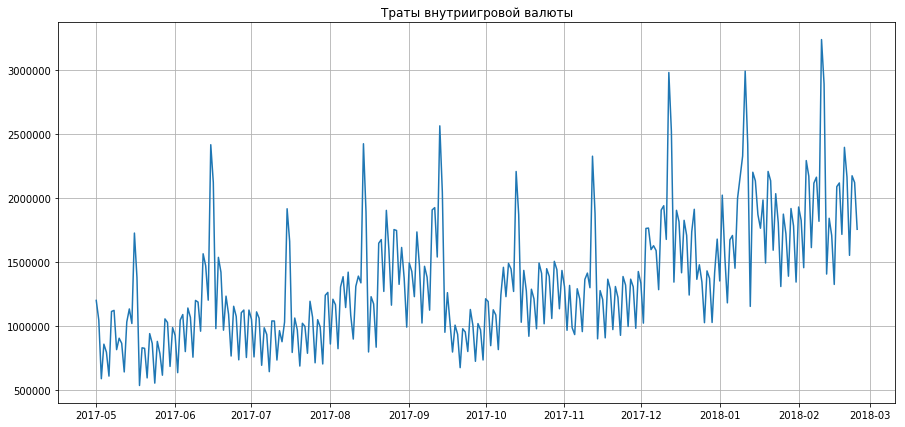

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

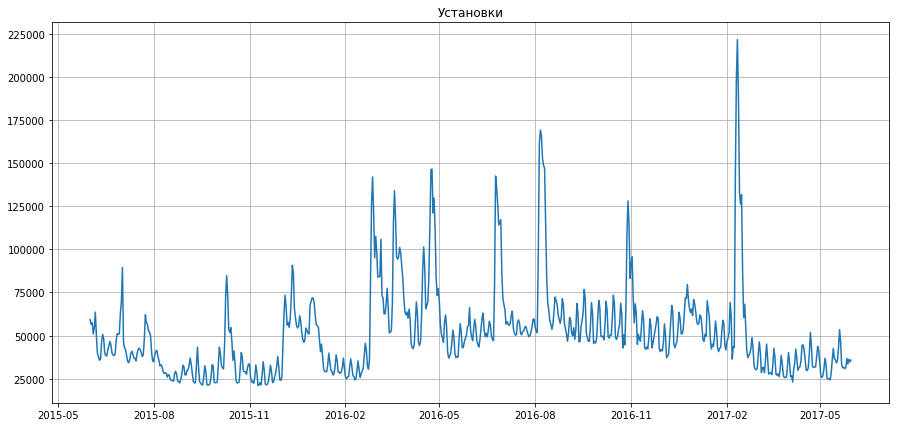

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(installs)
plt.title('Установки')
plt.grid(True)
plt.show()

У первого временного ряда явно есть и сезонность, и тренд, а вот второй ряд с установками имеет очень много выбросов, которые никак не характеризуются сезонными изменениями.

Для начала поработаем с моделью тройного экспоненциального сглаживания - моделью Хольта-Винтерса

In [5]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters                 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

Задание:

- Построить модель для временного ряда с установками, используя `mean_squared_error` в качестве функции потерь
- Сначала постройте модель на всём ряду installs.Users, отложив только последние 50 наблюдений для тестирования, убедитесь, что прогноз по такой модели будет сильно заниженным
- Теперь возьмите для моделирования только последние 500 наблюдений, для этого возьмите от временного ряда срез [500:-50], чтобы учесть в модели только последние изменения и не пытаться подогнать параметры под историю, которая уже стала нерелевантной

In [6]:
%%time
data = installs.Users[0:-50] # отложим 50 наблюдений для тестирования
slen = 7 # недельная сезонность
# инициализируем значения параметров
x = [0 ,0 ,0 ] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()



0.149589098089 0.0264877174616 0.127861504182
Wall time: 14 s


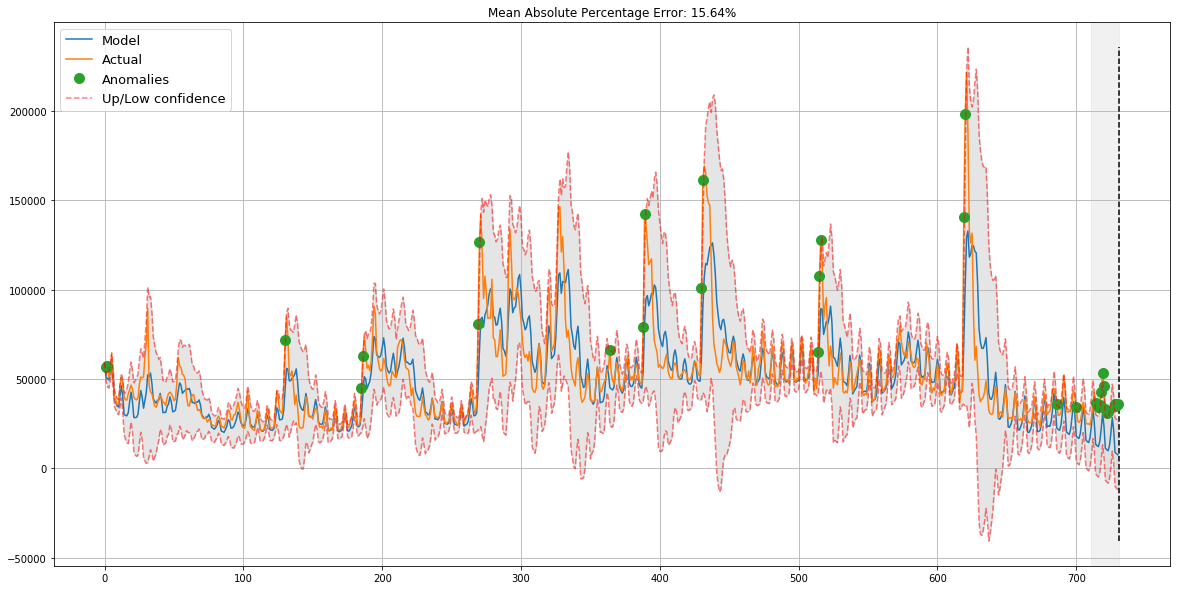

In [7]:
plotHoltWinters(installs.Users, plot_intervals=True, plot_anomalies=True)

А теперь обрежем наши данные, чтобы обучаться на последнем промежутке времени, наиболее релевантным для сегодняшних значений

In [8]:
%%time
data = installs.Users[500:-50] 
slen = 7
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )


# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.261882012619 0.0222188240662 0.0205416298673
Wall time: 4.42 s


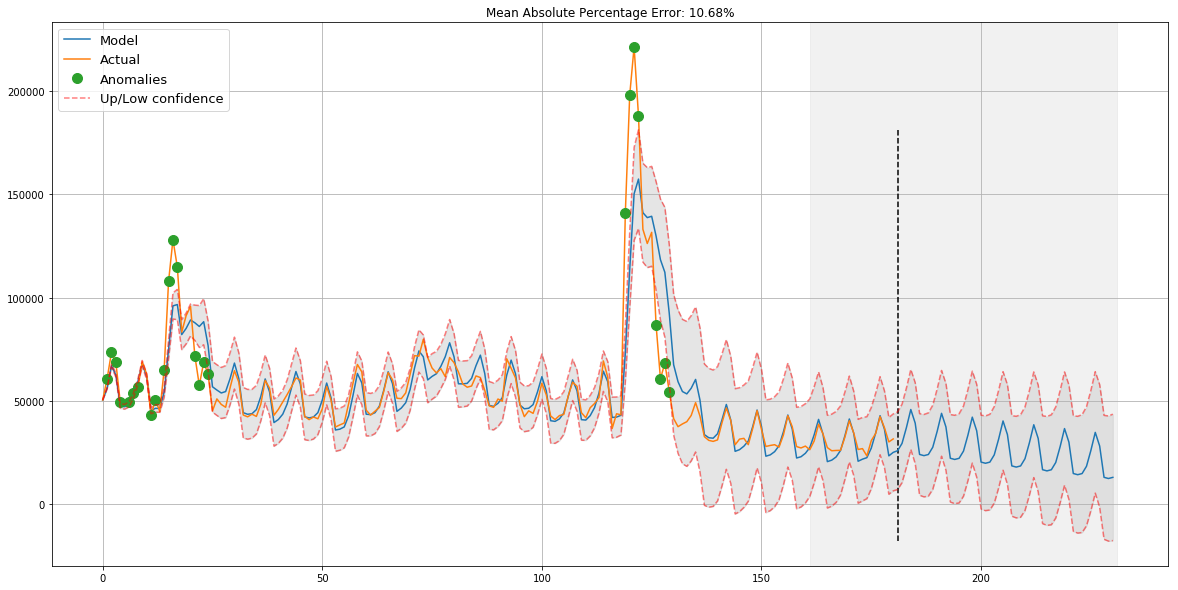

In [9]:
plotHoltWinters(installs.Users[500:-50], plot_intervals=True, plot_anomalies=True)

Прекрасно! Мы снова можем ловить аномалии, а модель неплохо описывает поведение нашего временного ряда и строит правдоподобный прогноз

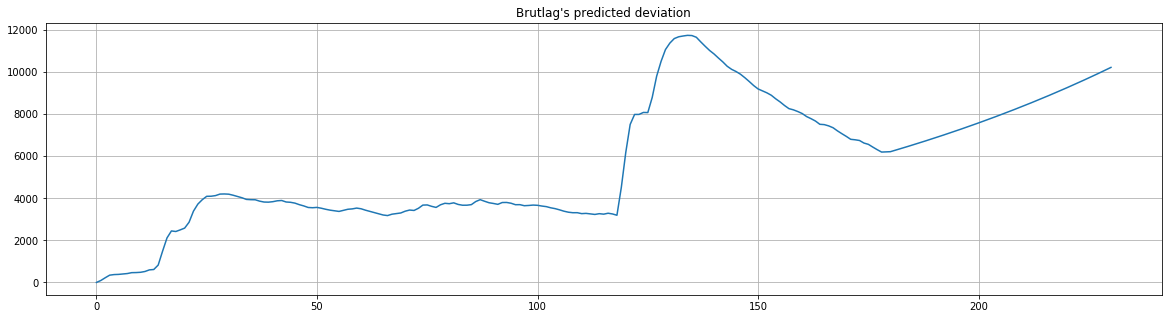

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

По графику смоделированной дисперсии легко увидеть, как выброс в наших данных значительно увеличил отклонение и вызвал расширение доверительных интерваловна некоторых промежуток времени

# Эконометрический подход

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [12]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [13]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

В качестве домашнего задания и хорошей практики для закрепления - по аналогии с лекцией построить модель SARIMA для прогнозирования временного ряда с тратой внутриигровой валюты, в котором присутствует тренд (убирается при помощи первых разностей) и месячная сезонность (сезонное дифференцирование с периодом 30)

Критерий Дики-Фуллера: p=0.372542


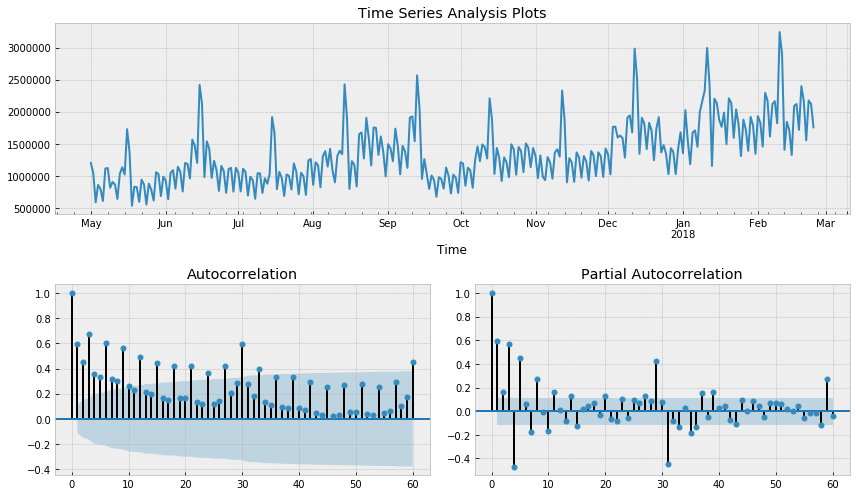

In [14]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

In [15]:
# TODO
# - привести ряд к стационарному виду
# - по ACF, PACF определить начальные значения параметров модели и возможные интервалы
# - перебором параметров подобрать оптимальную модель и построить её
# - построить график модельных значений и остатков, убедиться в адекватности результатов

In [16]:
gems_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(30)

Критерий Дики-Фуллера: p=0.002438


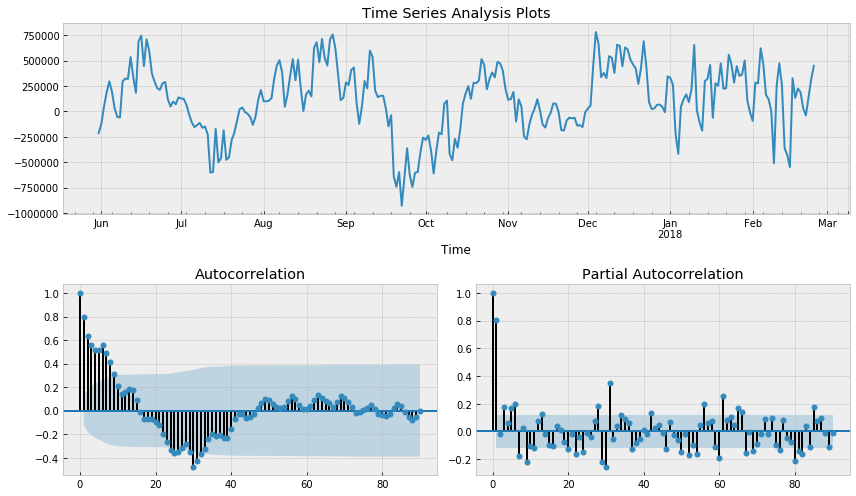

In [17]:
tsplot(gems_diff[30:], lags=90)

Критерий Дики-Фуллера: p=0.000061


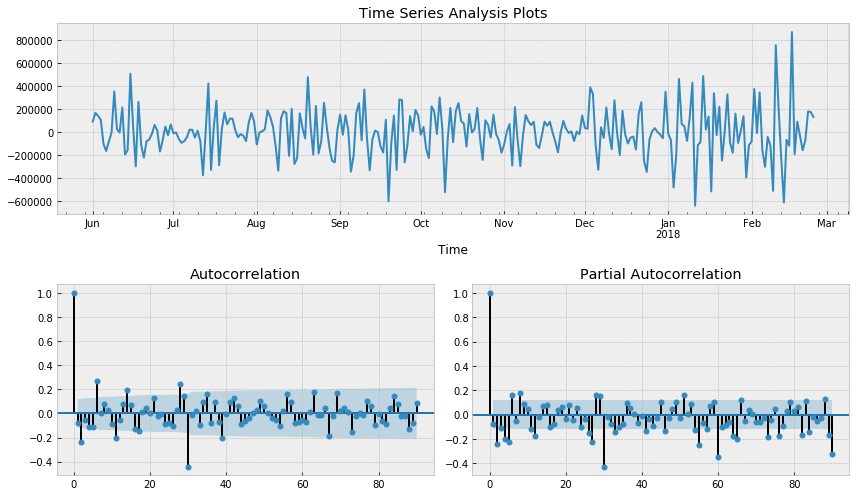

In [18]:
gems_diff = gems_diff - gems_diff.shift(1)
tsplot(gems_diff[30+1:], lags=90)

In [19]:
# p = 10
# d = 1
# q = 10

# P = 2
# D = 1
# Q = 1
# s = 24

In [23]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(2, 5)#11
d= 1
qs = range(2, 5)#11

Ps = range(0, 3)
D= 1
Qs = range(0, 2)
s = 30

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [24]:
parameters_list[:10]

[(2, 2, 0, 0),
 (2, 2, 0, 1),
 (2, 2, 1, 0),
 (2, 2, 1, 1),
 (2, 2, 2, 0),
 (2, 2, 2, 1),
 (2, 3, 0, 0),
 (2, 3, 0, 1),
 (2, 3, 1, 0),
 (2, 3, 1, 1)]

In [25]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

HBox(children=(IntProgress(value=0, max=54), HTML(value='')))


Wall time: 12min 9s


In [26]:
print(result_table)

      parameters          aic
0   (4, 4, 1, 1)  7233.317921
1   (4, 4, 0, 1)  7233.512551
2   (4, 4, 2, 1)  7233.553860
3   (4, 3, 2, 1)  7245.598758
4   (4, 3, 0, 1)  7245.599297
5   (4, 3, 1, 1)  7245.600088
6   (4, 2, 2, 1)  7247.708949
7   (4, 2, 0, 1)  7247.709183
8   (4, 2, 1, 1)  7247.709772
9   (3, 3, 0, 1)  7249.236105
10  (3, 3, 2, 1)  7249.236120
11  (3, 3, 1, 1)  7249.236147
12  (2, 3, 1, 1)  7261.842449
13  (2, 3, 2, 1)  7261.842449
14  (2, 3, 0, 1)  7261.842449
15  (3, 4, 1, 1)  7262.278393
16  (3, 4, 0, 1)  7262.278393
17  (3, 4, 2, 1)  7262.278393
18  (2, 4, 1, 1)  7265.588704
19  (2, 4, 0, 1)  7265.588704
20  (2, 4, 2, 1)  7265.588704
21  (2, 2, 2, 1)  7267.476713
22  (2, 2, 1, 1)  7267.476713
23  (2, 2, 0, 1)  7267.476713
24  (4, 2, 2, 0)  7295.353914
25  (4, 2, 0, 0)  7295.353914
26  (4, 2, 1, 0)  7295.353914
27  (4, 3, 1, 0)  7299.094090
28  (4, 3, 2, 0)  7299.094678
29  (4, 3, 0, 0)  7299.107660
30  (4, 4, 1, 0)  7299.764957
31  (4, 4, 2, 0)  7299.767020
32  (4, 4,

In [27]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(4, 1, 4)x(1, 1, 1, 30)   Log Likelihood               -3605.786
Date:                            Wed, 05 Dec 2018   AIC                           7233.572
Time:                                    16:01:53   BIC                           7273.114
Sample:                                05-01-2017   HQIC                          7249.452
                                     - 02-24-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2181      0.041      5.267      0.000       0.137       0.299
ar.L2         -0.7221      0.047   

# Machine Learning для временных рядов

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

scaler = StandardScaler()
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [29]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [30]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [31]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [32]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = data.index.to_datetime()
    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["month_average"] = list(map(code_mean(data[:test_index], 'month', "y").get, data.month))

        # выкидываем закодированные средними признаки 
        data.drop(["month", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

Снова небольшим домашним заданием будет построение моделей для временного ряда с внутриигровой валютой.

TODO

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"
- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше
- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат

Крутое бонус-задание
- Разбейте подготовленные данные на `train` и `test`
- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))
- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза
- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`
- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

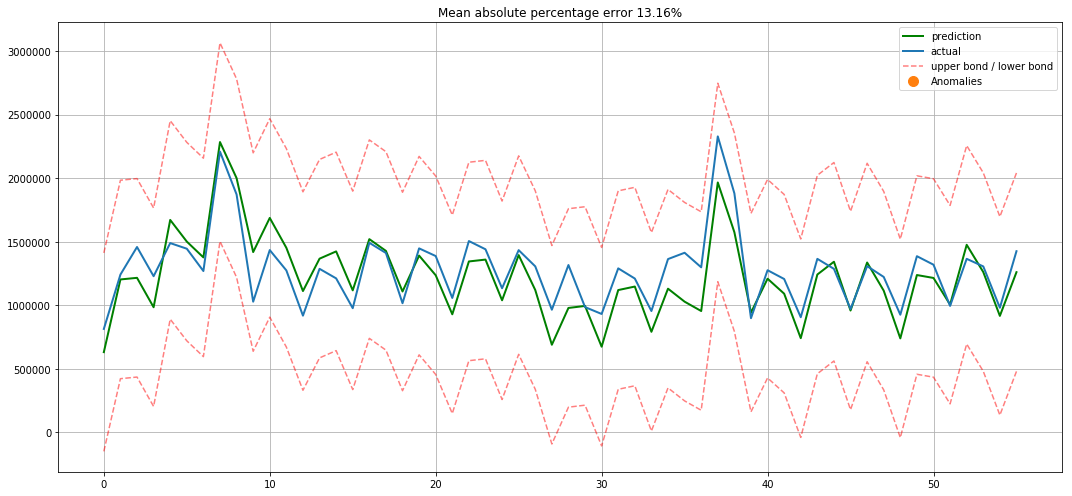

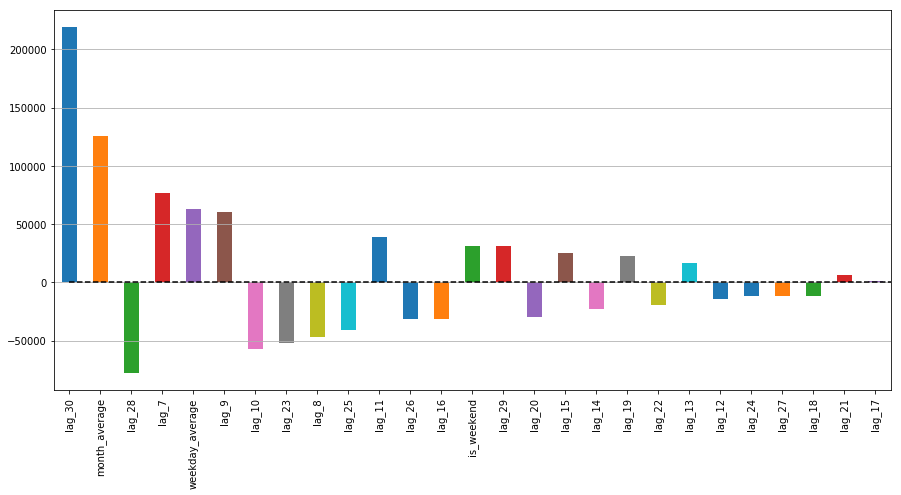

In [33]:
X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [34]:
def prepareData_a(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = data.index.to_datetime()
    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        
        # выкидываем закодированные средними признаки 
        data.drop(["weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

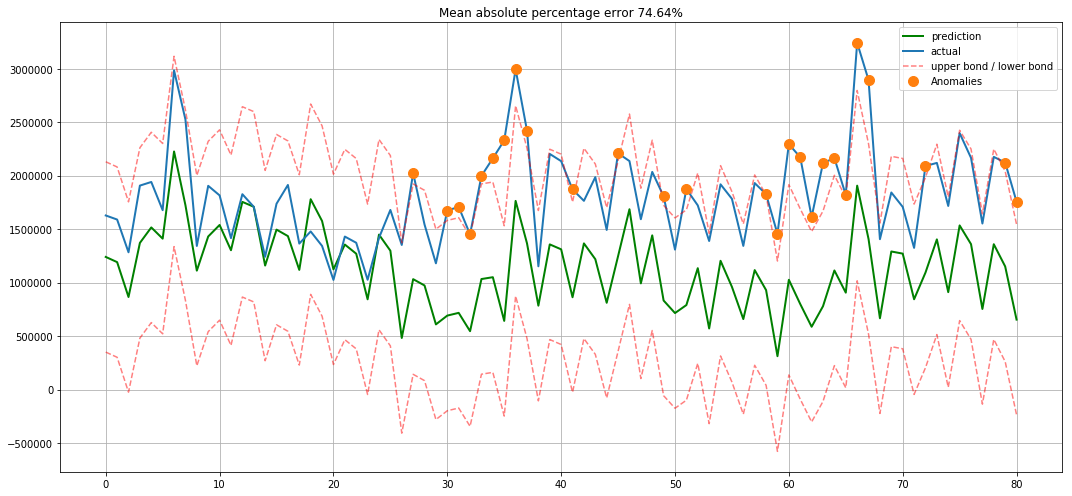

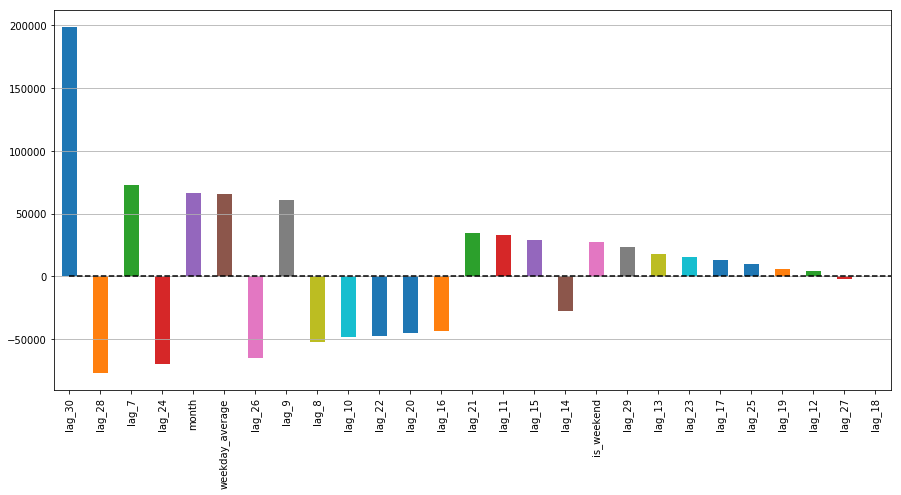

In [41]:
X_train, X_test, y_train, y_test =\
prepareData_a(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=True)

X_train_scaled_a = scaler.fit_transform(X_train)
X_test_scaled_a = scaler.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled_a, y_train)

plotModelResults(lr, X_train=X_train_scaled_a, X_test=X_test_scaled_a, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [38]:
from sklearn.linear_model import LassoCV, RidgeCV

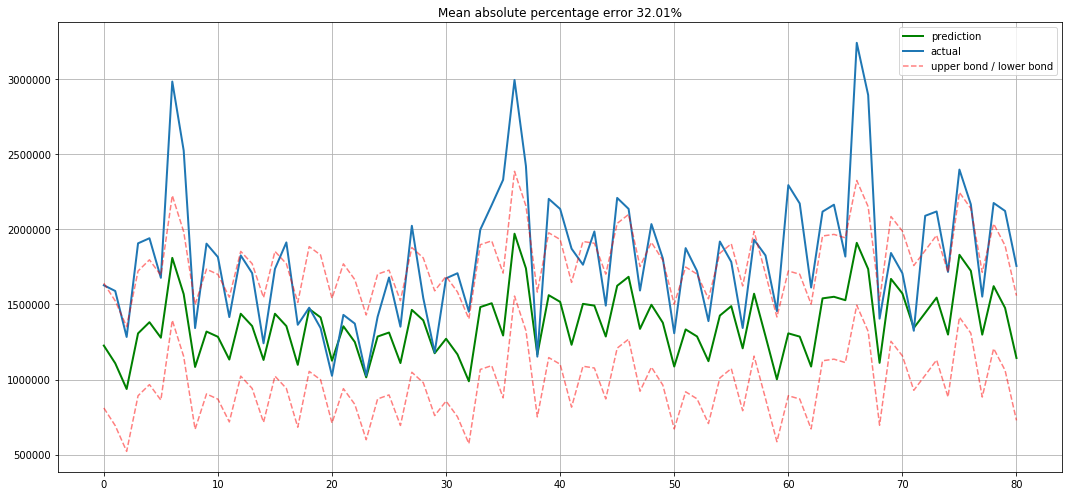

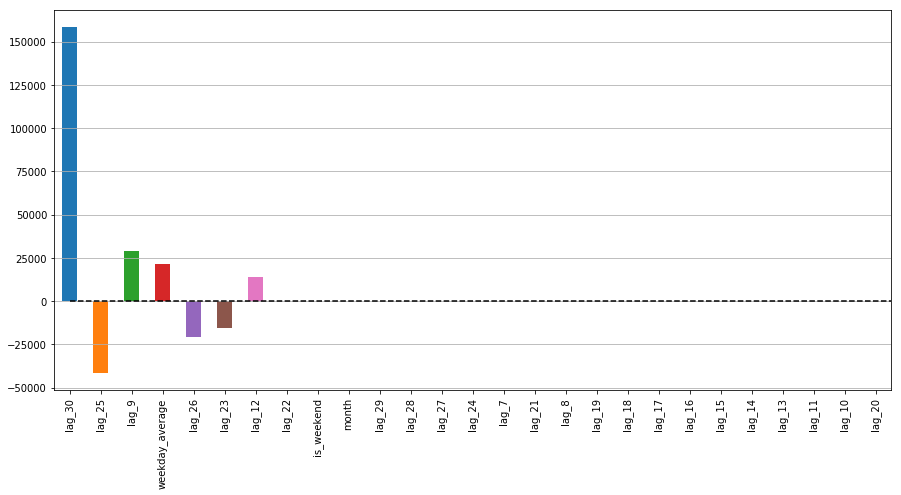

In [42]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled_a, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled_a, 
                 X_test=X_test_scaled_a, 
                 plot_intervals=True)
plotCoefficients(lasso)

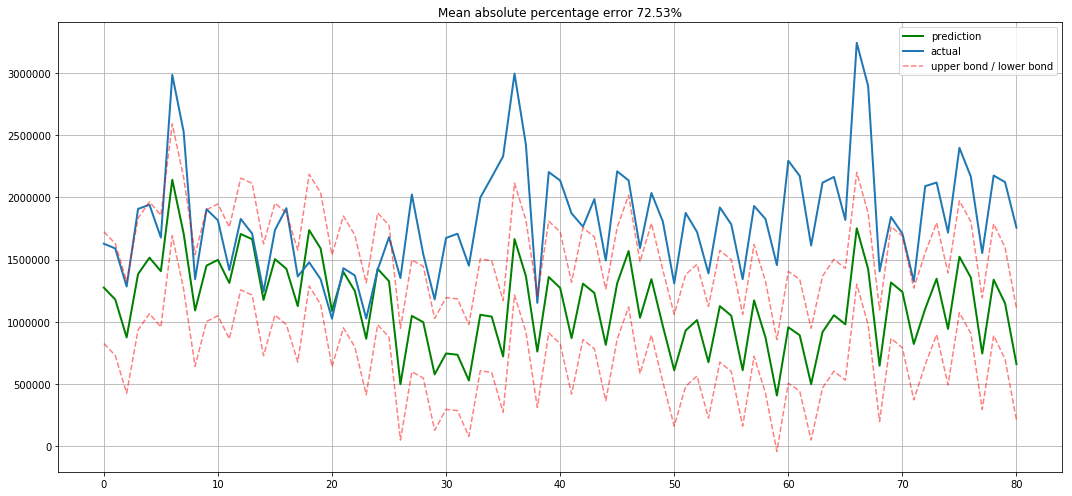

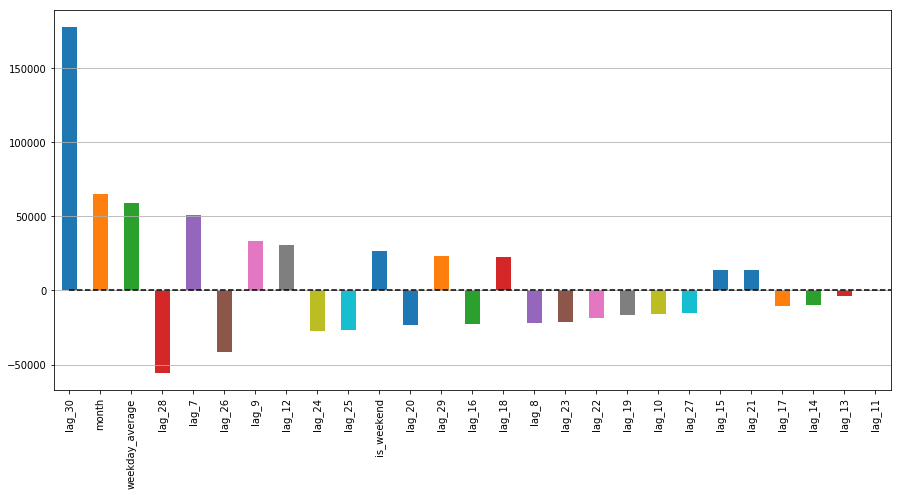

In [43]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(ridge)

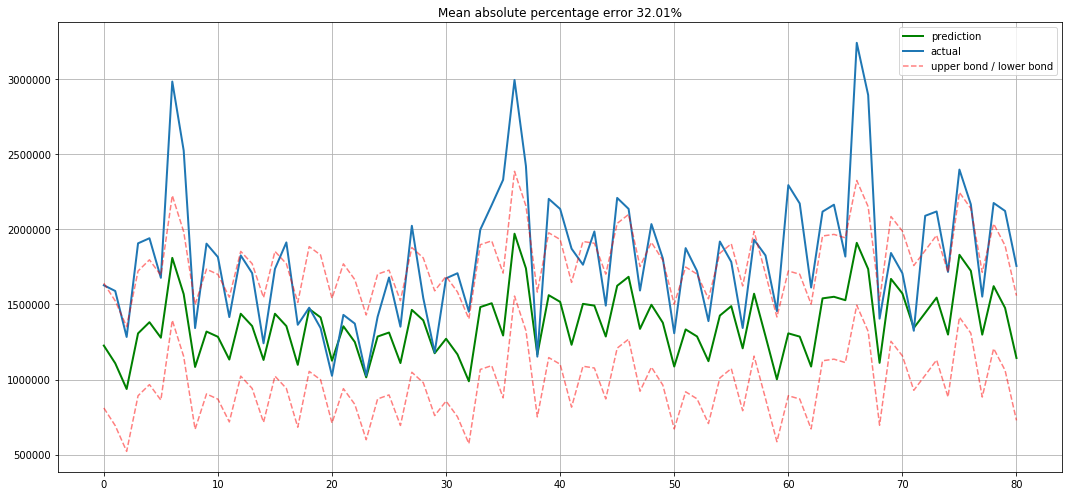

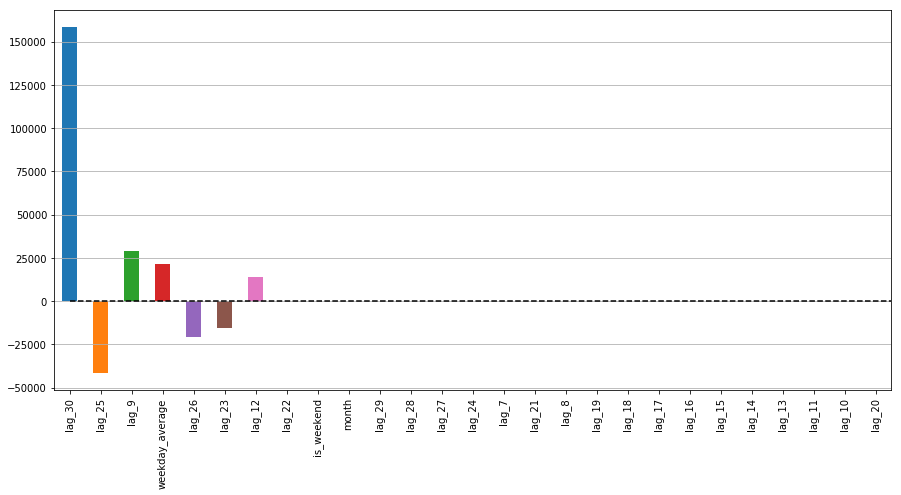

In [44]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(lasso)

In [45]:
from sklearn.ensemble import AdaBoostRegressor

In [46]:
ada=AdaBoostRegressor()

In [47]:
ada.fit(X_train_scaled, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

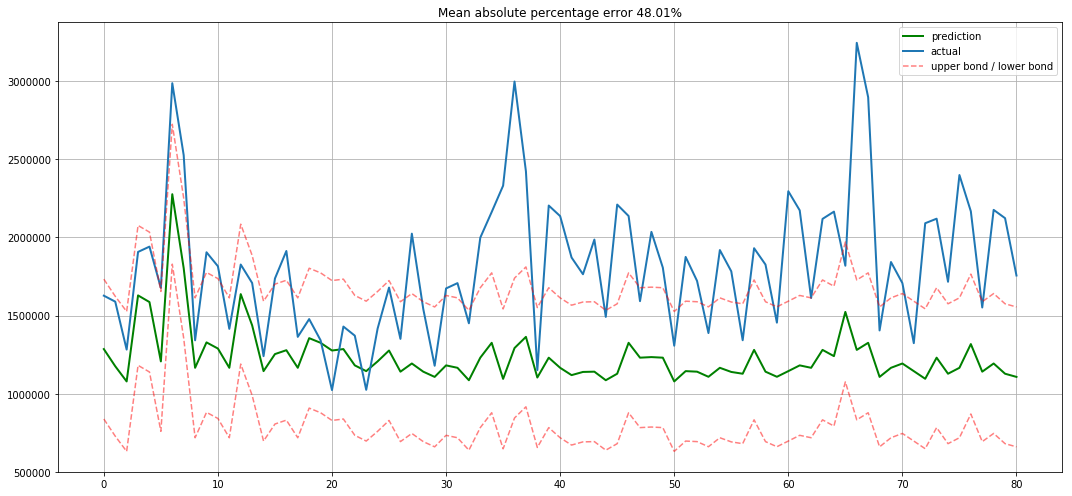

In [48]:
plotModelResults(ada, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)